### 机器学习工程师 -- 猫狗大战

#### 一、导入必要的包

In [75]:
import os
import cv2
import h5py
import random
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
from time import time
import matplotlib.pyplot as plt
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input, InceptionV3
from keras.applications.xception import Xception
from keras.models import Sequential, load_model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Lambda, BatchNormalization
from sklearn.model_selection import train_test_split
%matplotlib inline

#### 二、 读取图片的训练集和测试集

In [2]:
train_path, test_path = 'train/', 'test/' #读取训练集和测试集
train_files, test_files = os.listdir(train_path), os.listdir(test_path)

n_train_files = len(train_files)
n_test_files = len(test_files)

image_len = 299
n_label = int(n_train_files/2)

print("train文件夹中有{}张图片".format(n_train_files))
print("test文件夹中有{}张图片".format(n_test_files))

train文件夹中有25000张图片
test文件夹中有12500张图片


In [ ]:
plt.figure(figsize=(15, 15))
for i, train_file in tqdm(enumerate(random.sample(train_files, 16))):
    plt.subplot(4, 4, i+1)
    image = cv2.cvtColor(cv2.imread(os.path.join(train_path, train_file)), cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(train_file)

2.这里把图片从硬盘中读到内存里，并且打上正负标签，把狗的标签打成1，猫的标签打成0

(如果觉得图片读取太浪费时间，可以直接点击<a href="#hdf5读取">这里</a>,直接读取本地的images.hdf5文件)

In [3]:
X = np.zeros((n_train_files, image_len, image_len,3), dtype=np.uint8)
X_test = np.zeros((n_test_files, image_len, image_len, 3), dtype=np.uint8)
y = np.zeros((n_train_files,), dtype=np.uint8)

for i in tqdm(range(n_label)):
    X[i] = cv2.cvtColor(cv2.resize(cv2.imread("{}cat.{}.jpg".format(train_path,i)), (image_len, image_len)), cv2.COLOR_BGR2RGB)
    X[i+n_label] = cv2.cvtColor(cv2.resize(cv2.imread("{}dog.{}.jpg".format(train_path,i)), (image_len, image_len)), cv2.COLOR_BGR2RGB)
    X_test[i] = cv2.cvtColor(cv2.resize(cv2.imread('test/{}.jpg'.format(i+1)), (image_len, image_len)),cv2.COLOR_BGR2RGB)
    y[n_label:] = 1

100%|██████████| 12500/12500 [01:29<00:00, 140.25it/s]


3.这里发现读图片就用了两分多钟，接下来把使用h5py模块把X和y保存下来，这样下次读取就快多了。

In [ ]:
with h5py.File("images", 'w') as f:
    f['train'] = X
    f['lanel'] = y
    f['text'] = X_test

<a id='hdf5读取'></a>
4.这里直接用h5py模块读取实现保存好的images.hdf5,然后查看读取的数据，X和y的维度，和数据类型

In [ ]:
with h5py.File("images", 'r') as f:
    X = f['train']
    y = f['label']
    X_test = f['text']

In [4]:
print("X的维度是{}， 数据类型是{}".format(X.shape, X.dtype))
print("y的维度是{}， 数据类型是{}".format(y.shape, y.dtype))
print("X_test的维度是{}， 数据类型是{}".format(X_test.shape, X_test.dtype))

X的维度是(25000, 299, 299, 3)， 数据类型是uint8
y的维度是(25000,)， 数据类型是uint8
X_test的维度是(12500, 299, 299, 3)， 数据类型是uint8


对调整好的图片再次可视化

In [ ]:
plt.figure(figsize=(15, 15))
for i in tqdm(range(16)):
    random_index = random.randint(0, n_train_files-1)
    plt.subplot(4, 4, i+1)
    image = X[random_index]
    plt.imshow(image)
    plt.title(['cat', 'dog'][y[random_index]])

方便获取特征呢构建get_features函数

In [11]:
def get_features(Model, data):
    model = Sequential()
    base_model = Model(weights='imagenet', include_top=False, input_shape = (image_len, image_len, 3))
    model.add(Lambda(preprocess_input, name='preprocessing', input_shape=(image_len, image_len, 3)))
    model.add(base_model)
    model.add(GlobalAveragePooling2D())

    feature = model.predict(data, batch_size=128, verbose=1)
    return feature

fusion_model对两个函数进行权重融合

In [12]:
def fusion_model(model1, model2, dataset):
    first_feature = get_features(model1, dataset)
    second_feature = get_features(model2, dataset)
    features = np.concatenate([first_feature, second_feature], axis=-1)
    return features

将InceptionV3，Xception两个模型进行拼接

In [13]:
train_features = fusion_model(InceptionV3, Xception, X)
feature_test = fusion_model(InceptionV3, Xception, X_test)

12500/12500 [==============================] - 283s 23ms/step


In [ ]:
with h5py.File('features', 'w') as d:
    d['features'] = features

In [ ]:
with h5py.File('features', 'r') as d:
    features = np.array(d['features'])

搭建后续的模型

In [142]:
cnn_model = Sequential()
cnn_model.add(Dropout(0.3, input_shape = train_features.shape[1:], name='Dropout_layer'))
# cnn_model.add(BatchNormalization(name='BN'))
cnn_model.add(Dense(1, activation='sigmoid', name='Dense_end'))
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dropout_layer (Dropout)      (None, 4096)              0         
_________________________________________________________________
Dense_end (Dense)            (None, 1)                 4097      
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


In [143]:
cnn_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adadelta(),
              metrics=['accuracy'])

In [144]:
X_train, X_valid, y_train, y_valid = train_test_split(train_features, y, test_size=0.2, random_state=42)

In [145]:
start = time()
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
h = cnn_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=128, callbacks=[early_stopping])
end = (time()-start)/60
print("训练时间 {:.2f}分钟".format(end))

Train on 20000 samples, validate on 5000 samples
Epoch 1/100
20000/20000 [==============================] - 23s 1ms/step - loss: 0.0894 - acc: 0.9805 - val_loss: 0.0283 - val_acc: 0.9936
Epoch 2/100
20000/20000 [==============================] - 1s 61us/step - loss: 0.0213 - acc: 0.9945 - val_loss: 0.0205 - val_acc: 0.9938
Epoch 3/100
20000/20000 [==============================] - 1s 59us/step - loss: 0.0161 - acc: 0.9949 - val_loss: 0.0187 - val_acc: 0.9936
Epoch 4/100
20000/20000 [==============================] - 1s 61us/step - loss: 0.0135 - acc: 0.9959 - val_loss: 0.0188 - val_acc: 0.9940
Epoch 5/100
20000/20000 [==============================] - 1s 64us/step - loss: 0.0130 - acc: 0.9959 - val_loss: 0.0182 - val_acc: 0.9946
Epoch 6/100
20000/20000 [==============================] - 1s 61us/step - loss: 0.0118 - acc: 0.9962 - val_loss: 0.0184 - val_acc: 0.9942
Epoch 7/100
20000/20000 [==============================] - 1s 61us/step - loss: 0.0116 - acc: 0.9963 - val_loss: 0.0191 - v

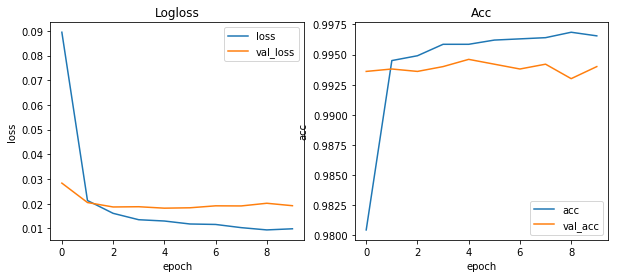

In [146]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Logloss")

plt.subplot(1,2,2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title("Acc");

#### 使用测试集

In [147]:
y_pred = cnn_model.predict(feature_test, batch_size=128, verbose=1)

12500/12500 [==============================] - 9s 744us/step


In [148]:
df = pd.read_csv("sample_submission.csv")
df['label'] = y_pred.clip(min=0.05, max=0.995)
df.to_csv('pred.csv', index=None)

In [149]:
!kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f pred.csv -m "Message"

100%|█████████████████████████████████████████| 132k/132k [00:00<00:00, 240kB/s]
Successfully submitted to Dogs vs. Cats Redux: Kernels Edition